# Hyper Parameter Optimization For LightGBM

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'LightGBM'

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\HPO'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

In [6]:
dft_train.shape, dft_test.shape, exp_train.shape, exp_test.shape

((4412, 134), (1108, 134), (1595, 134), (335, 134))

## Model Train

### DFT Model

In [8]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")

# create a pipeline with a scaler and the LightGBM model
lgbm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm',  LGBMRegressor(objective='regression', metric='rmse', random_state=RANDOM_SEED,
            verbosity=0, n_jobs=-1))
])

# define the parameter grid for the LightGBM model(total 128 combinations)
param_grid = {
    'lgbm__n_estimators': [200, 300],
    'lgbm__max_depth': [-1, 5, 7, 9],
    'lgbm__learning_rate': [0.05, 0.1, 0.2, 0.3],
    'lgbm__subsample': [0.7, 1.0],
    'lgbm__colsample_bytree': [0.7, 1.0]
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a GridSearchCV object
# grid_search = GridSearchCV(
#     estimator=lgbm_pipe, 
#     param_grid=param_grid, 
#     scoring='neg_mean_squared_error', 
#     cv=kf, 
#     n_jobs=-1, 
#     verbose=1,
#     return_train_score=True)
# n_iter=5, time=20s
grid_search = RandomizedSearchCV(estimator=lgbm_pipe, param_distributions=param_grid,
                n_iter=60, cv=kf, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

['DFT LightGBM'] HP optimazation begin...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lgbm',
                                              LGBMRegressor(metric='rmse',
                                                            n_jobs=-1,
                                                            objective='regression',
                                                            random_state=42,
                                                            verbosity=0))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'lgbm__colsample_bytree': [0.7, 1.0],
                                        'lgbm__learning_rate': [0.05, 0.1, 0.2,
                                                                0.3],
                                        'lgbm__max_depth': [-1, 5, 7, 9],
                                        'lgbm__n_estimators': [200, 300],
                                        'lgbm__subsample': [0.7, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_lgbm__learning_rate', 'param_lgbm__max_depth', 
                                 'param_lgbm__n_estimators', 'param_lgbm__subsample', 'param_lgbm__colsample_bytree',
                                 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'LightGBM_dft_hp.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'lgbm__subsample': 0.7, 'lgbm__n_estimators': 300, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.1, 'lgbm__colsample_bytree': 0.7}
Best Cross-Validation RMSE: 0.5394


,rank_test_score,param_lgbm__learning_rate,param_lgbm__max_depth,param_lgbm__n_estimators,param_lgbm__subsample,param_lgbm__colsample_bytree,train_rmse,test_rmse
11,1,0.1,7,300,1.0,0.7,0.192490,0.539356
9,1,0.1,7,300,0.7,0.7,0.192490,0.539356
3,3,0.1,9,300,1.0,0.7,0.168237,0.540545
43,3,0.1,9,300,0.7,0.7,0.168237,0.540545
20,5,0.1,-1,300,0.7,0.7,0.153671,0.540843


### Overfitting check

####################################################################################################
[DFT - LightGBM] Training LightGBM on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


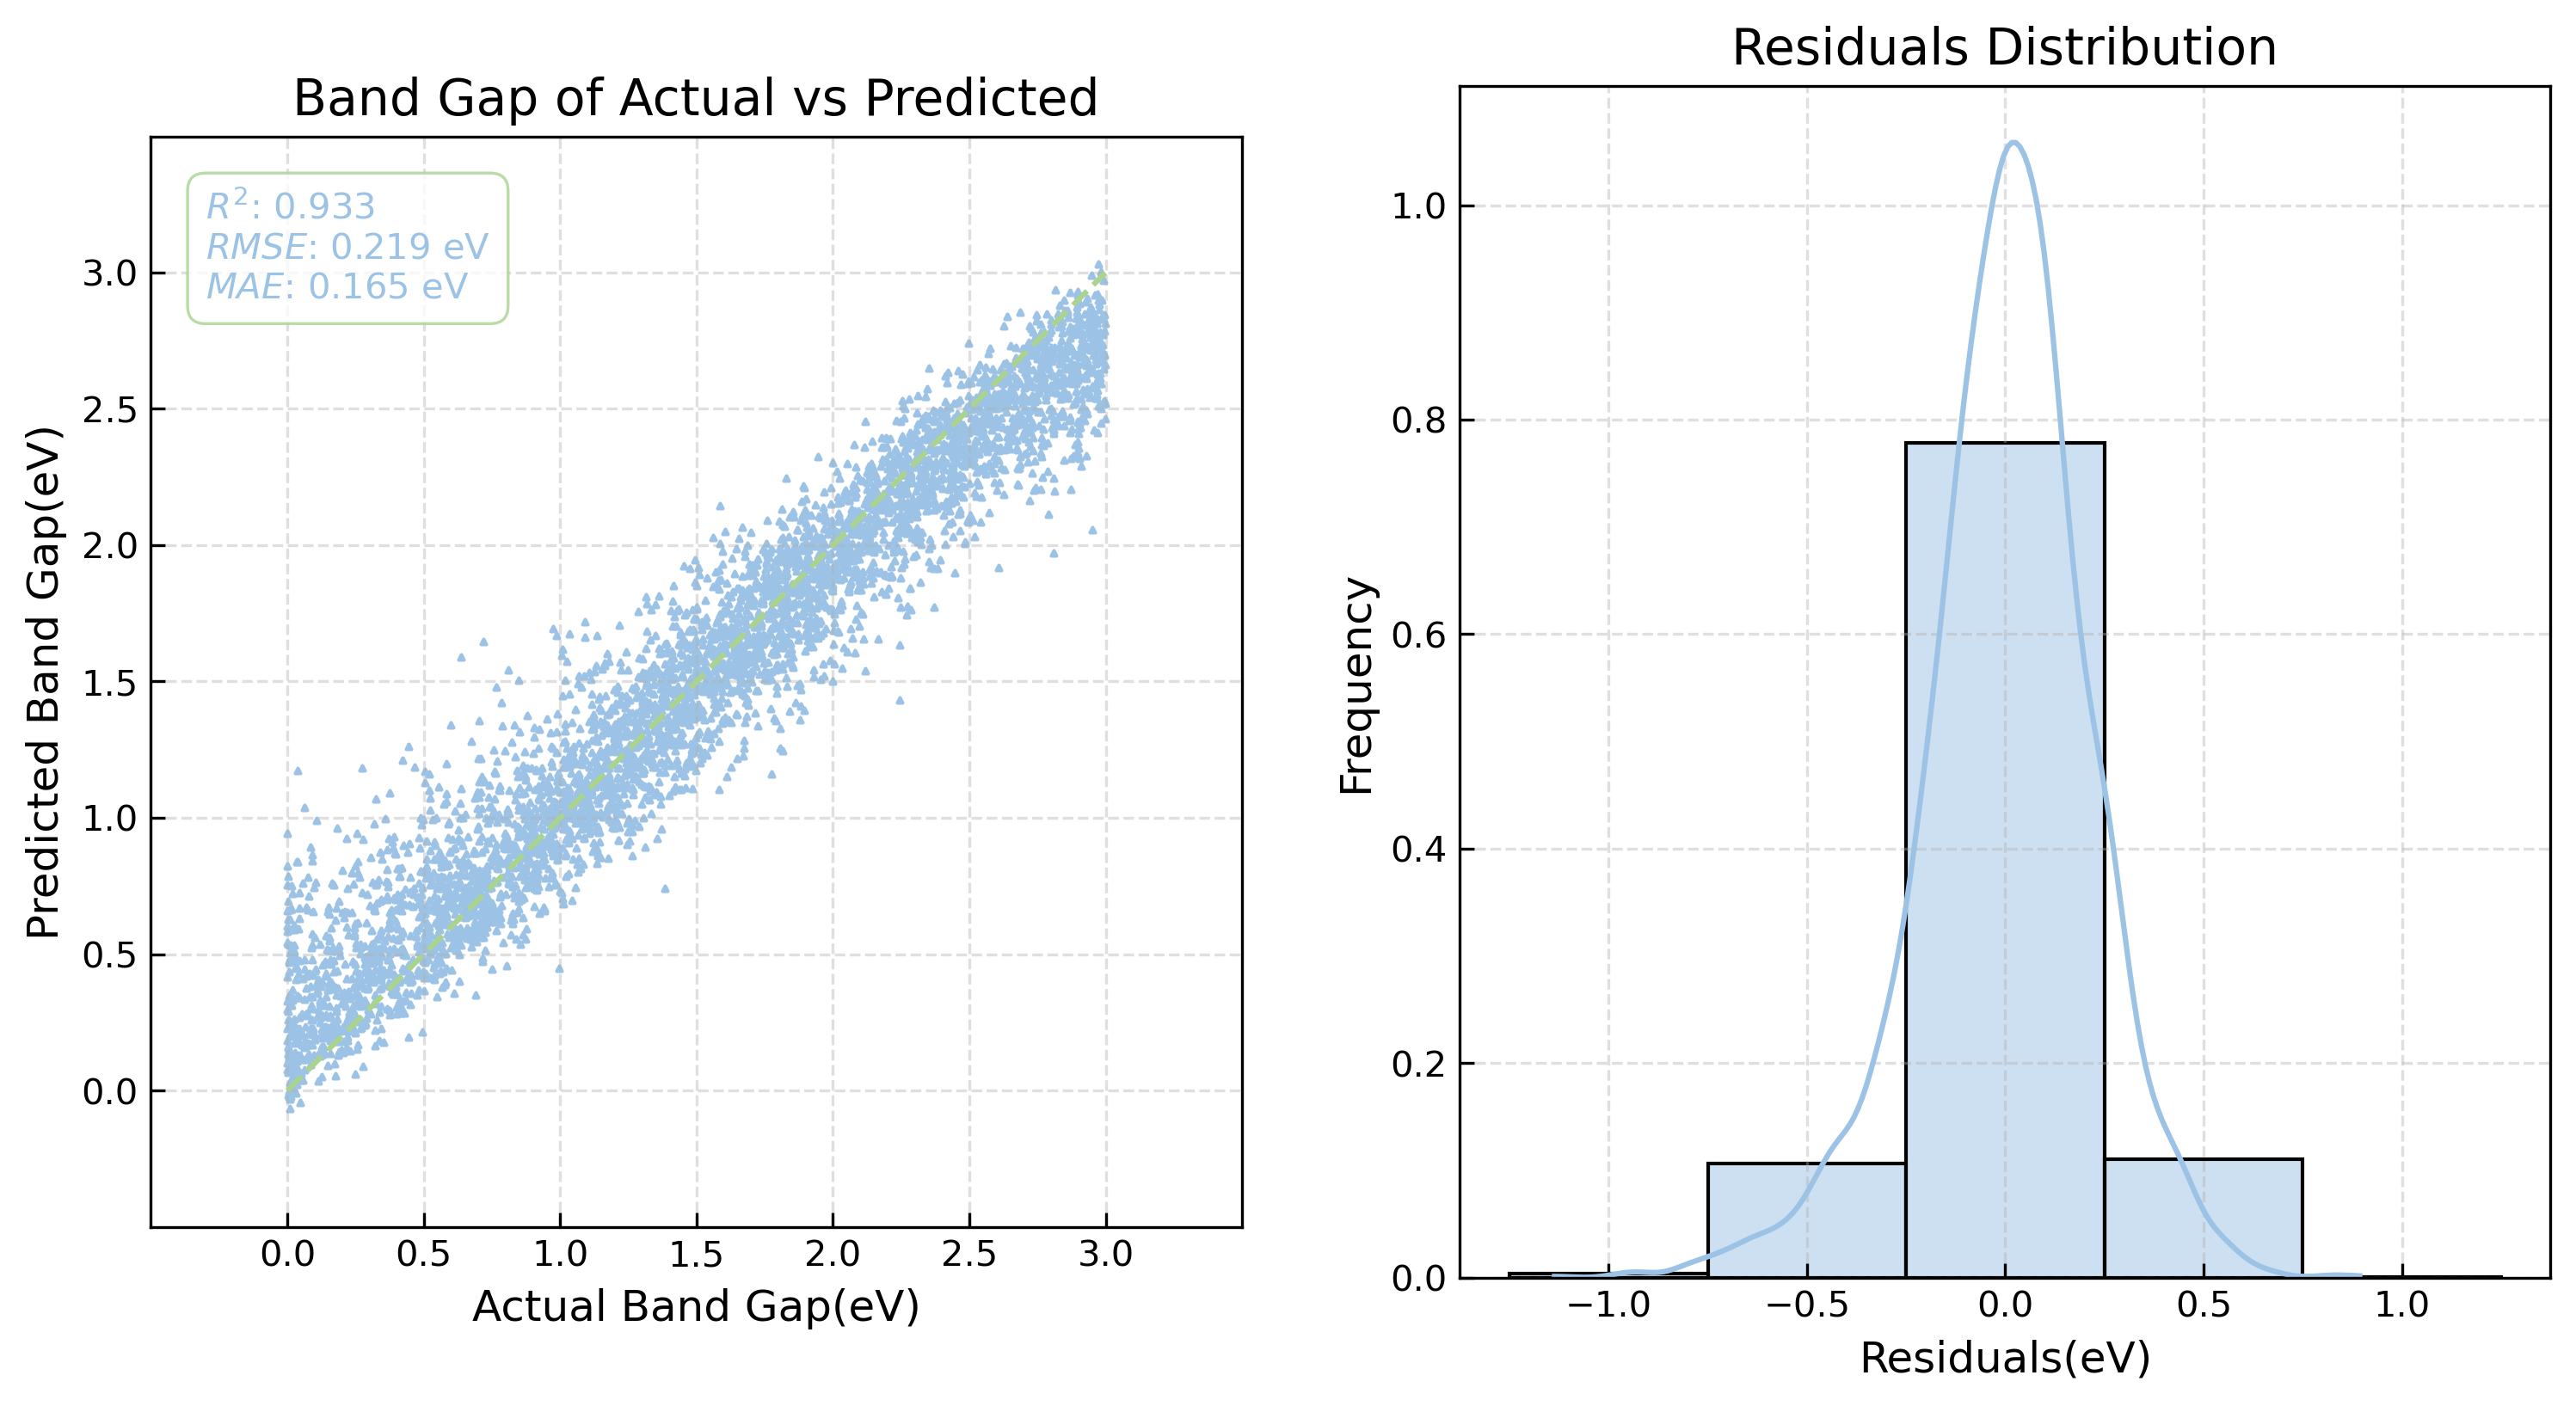


Model Evaluation Results:
Test set size: 4412
Test set: R²: 0.9326 RMSE: 0.2195 MAE: 0.1654 MAPE: 932.7275%
[Test DFT -> DFT] Evaluating DFT LightGBM on DFT test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


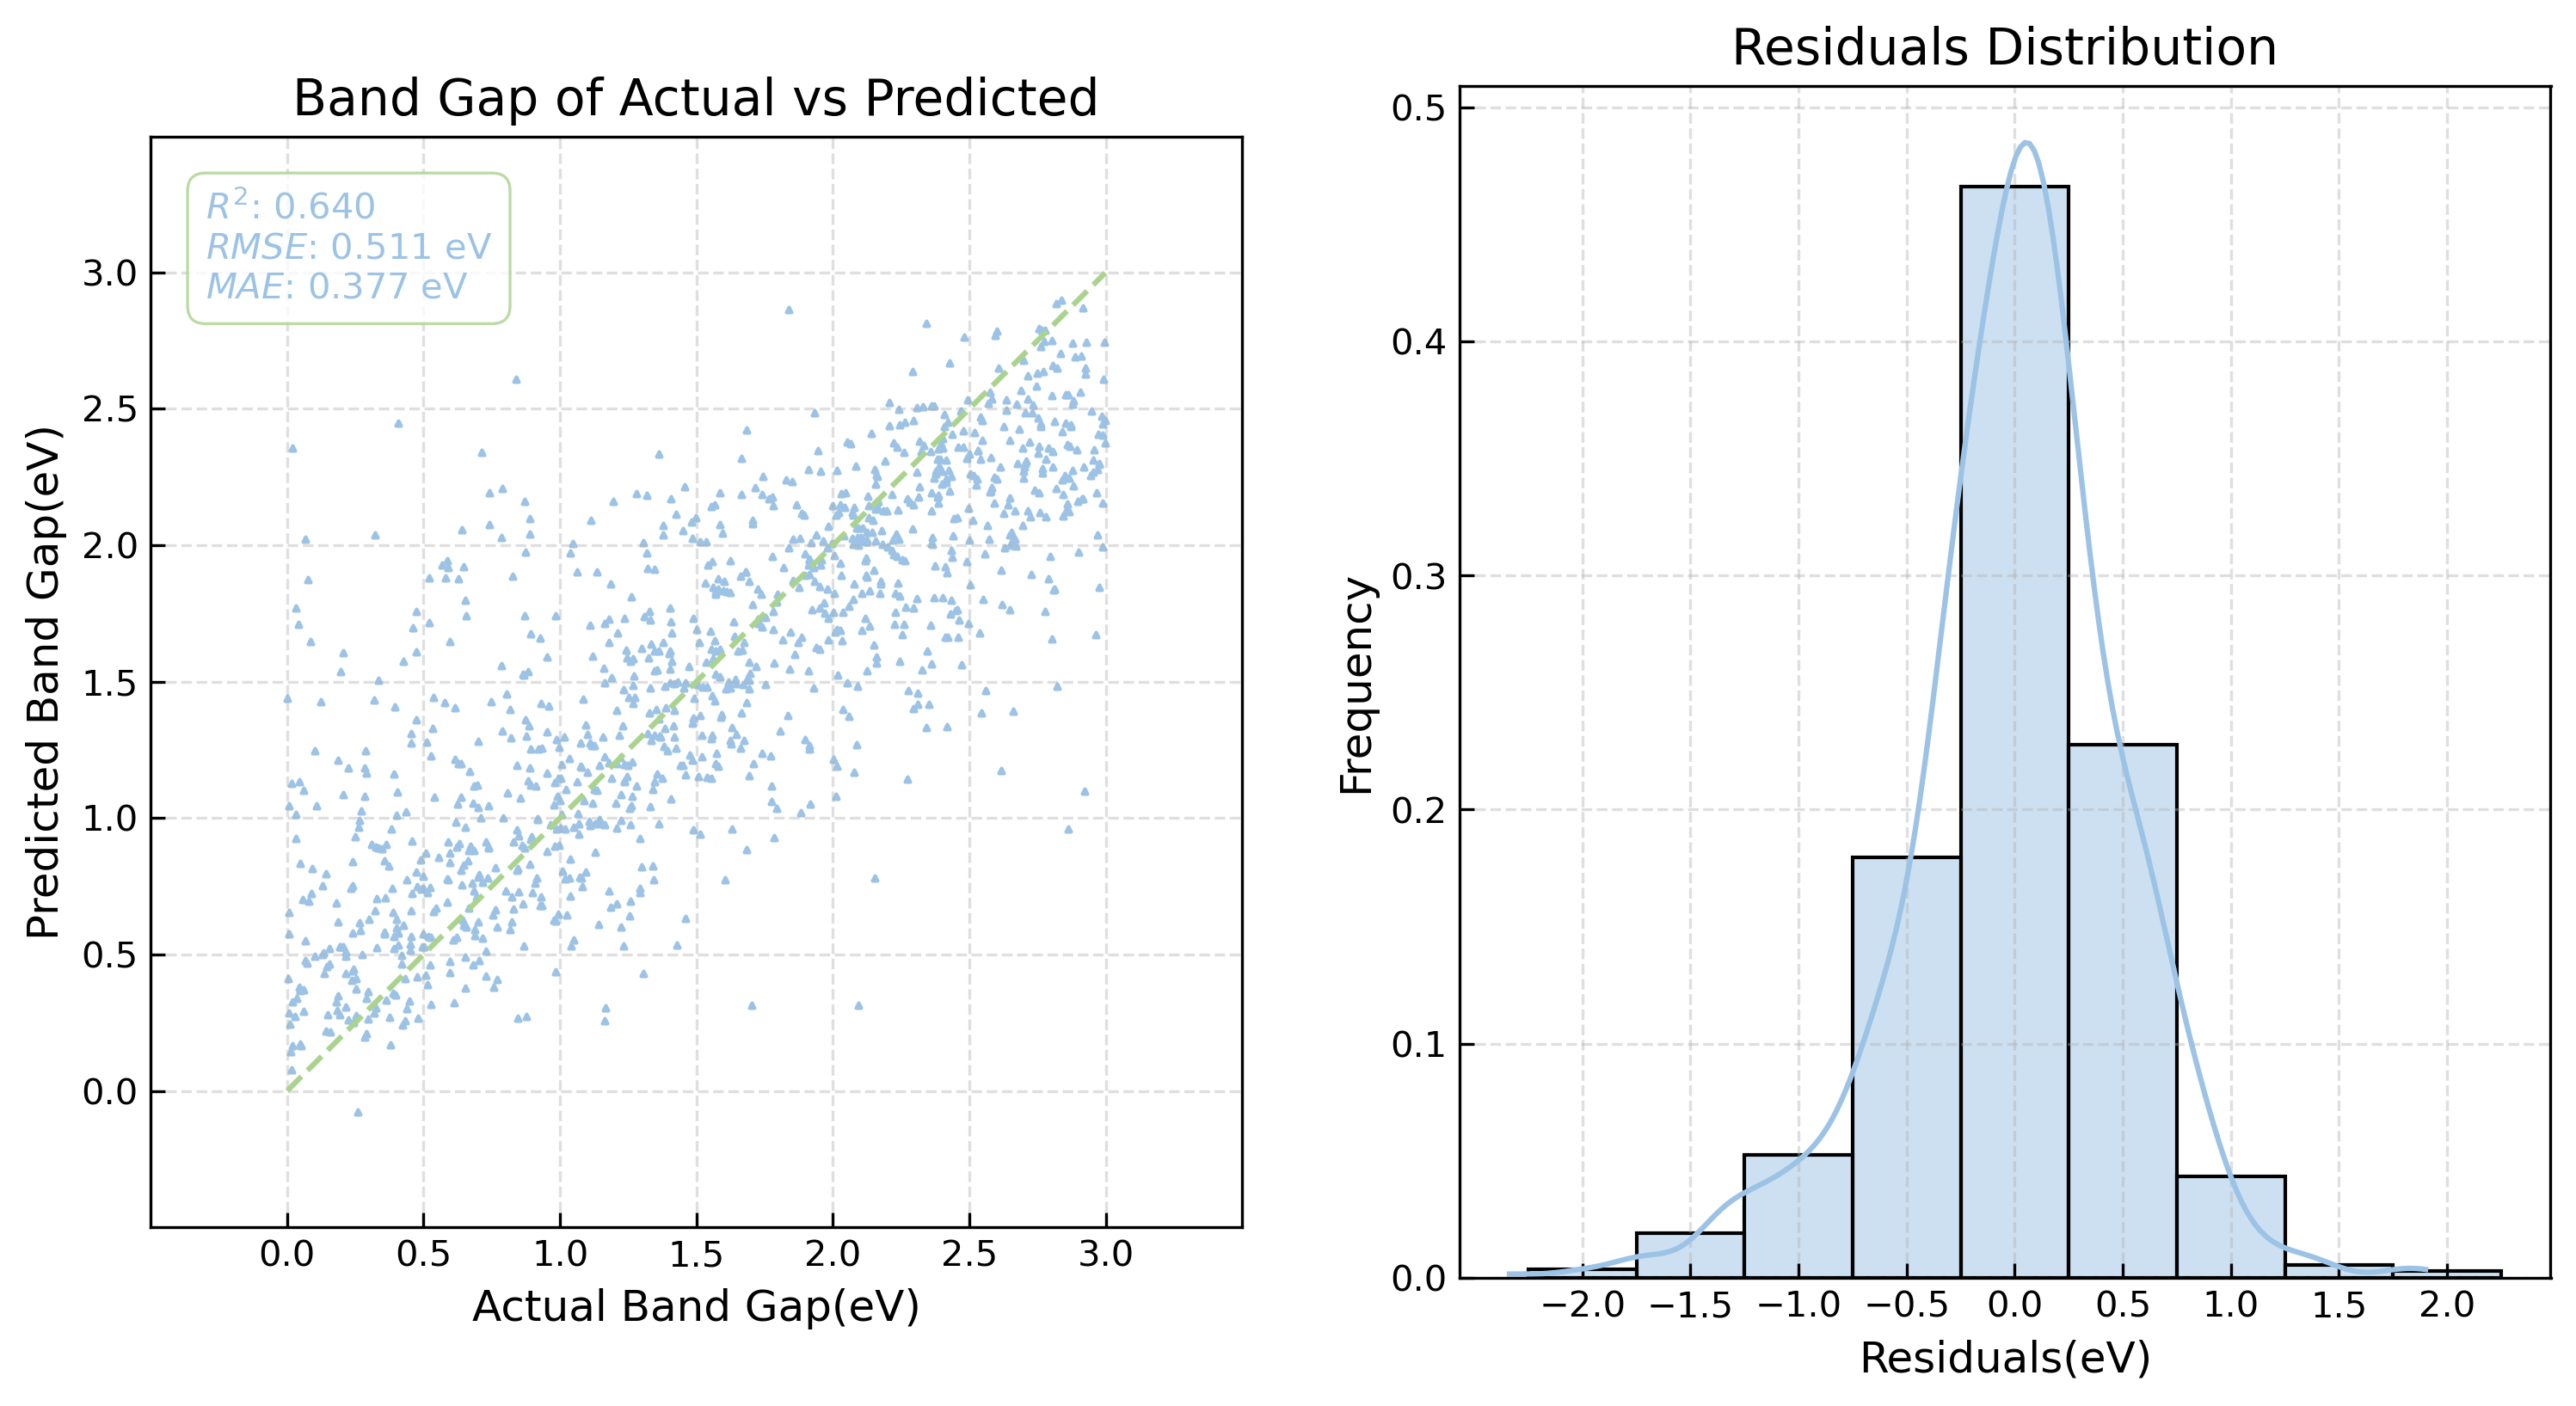


Model Evaluation Results:
Test set size: 1108
Test set: R²: 0.6397 RMSE: 0.5110 MAE: 0.3768 MAPE: 259.7445%
[Test DFT -> EXP] Evaluating DFT LightGBM on EXP test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


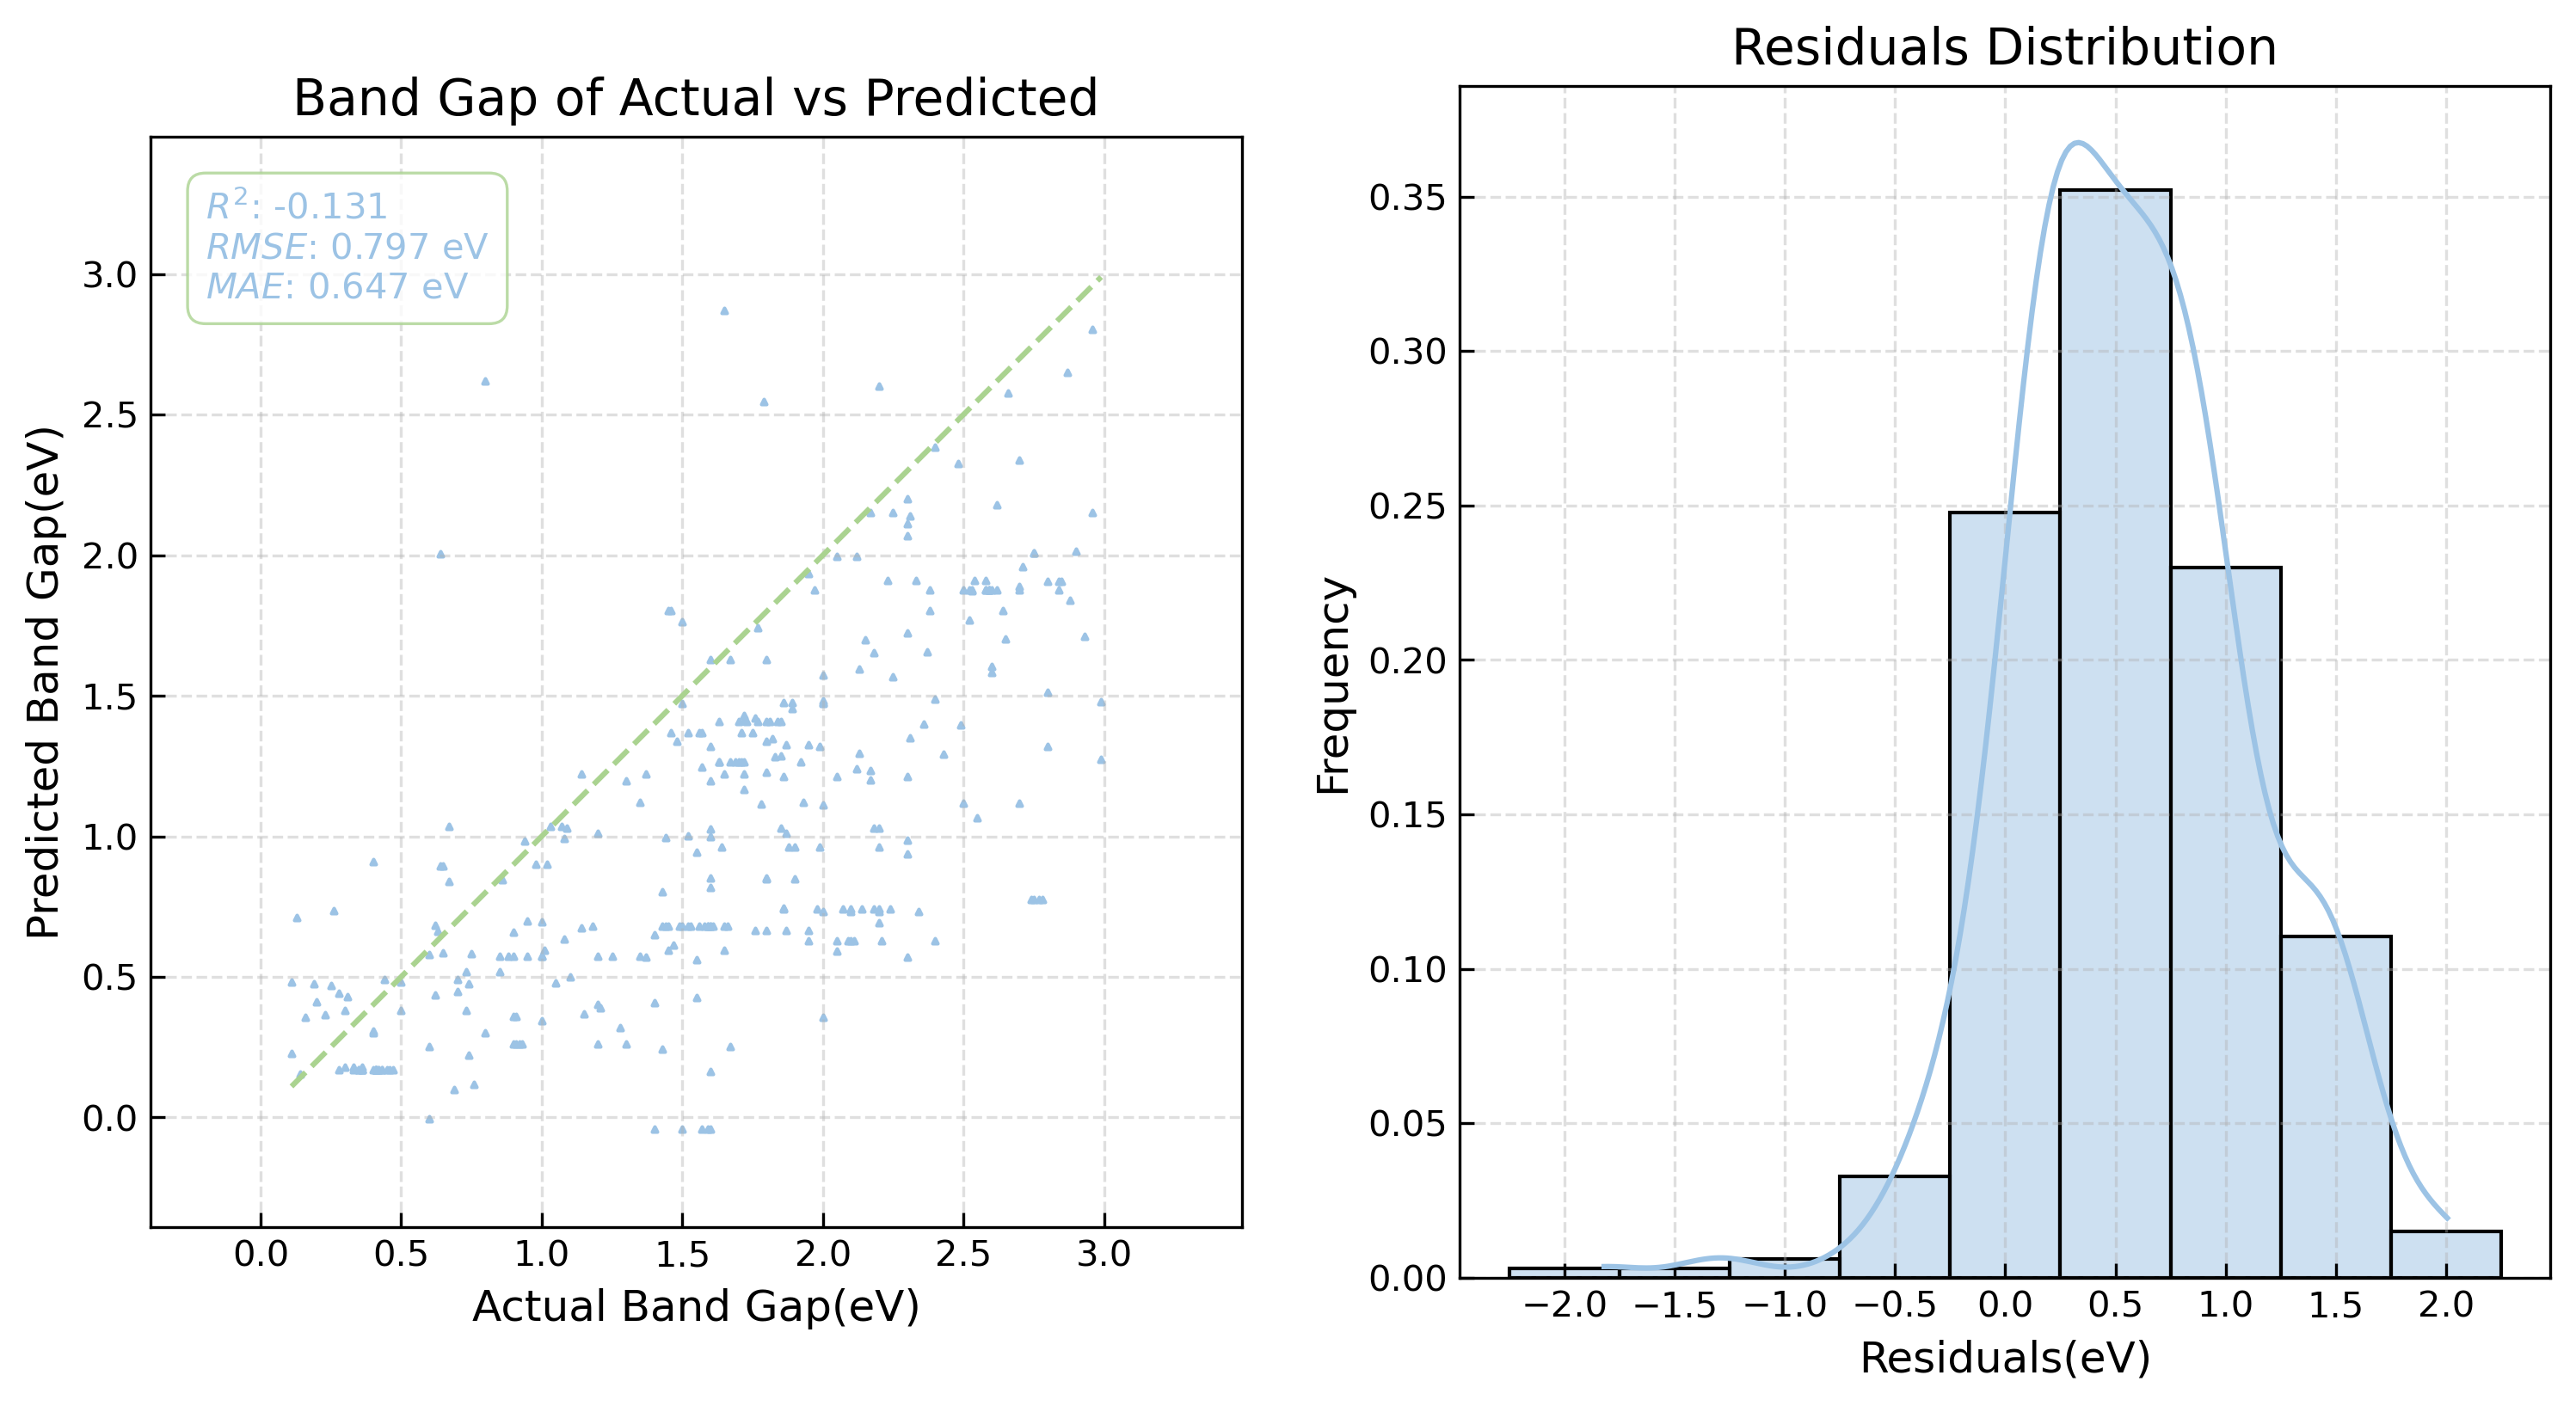


Model Evaluation Results:
Test set size: 335
Test set: R²: -0.1314 RMSE: 0.7969 MAE: 0.6472 MAPE: 45.7206%


In [10]:
# 
# Train the model with the best hyperparameters on the entire training set
lightgbm_best = LGBMRegressor(learning_rate=0.1, max_depth=7, n_estimators=300,
                subsample=1.0, colsample_bytree=0.7, objective='regression',
                random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(lightgbm_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [11]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,LightGBM,Train,dft,dft,0.932587,0.219467,0.165374
1,LightGBM,Test,dft,dft,0.639727,0.511012,0.376762
2,LightGBM,Test,dft,exp,-0.131364,0.796909,0.647217


### EXP Model

In [14]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")
# create a pipeline with a scaler and the LightGBM model
lgbm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm',  LGBMRegressor(objective='regression', metric='rmse', random_state=RANDOM_SEED,
        n_jobs=-1, verbose=0))
])
# define the parameter grid for the LightGBM model(total 1728 combinations)
param_grid = {
    'lgbm__n_estimators': [200, 300],
    'lgbm__max_depth': [-1, 5, 7, 9],
    'lgbm__learning_rate': [0.05, 0.1, 0.2, 0.25, 0.3],
    'lgbm__reg_alpha': [0, 0.1, 0.3],
    'lgbm__reg_lambda': [0, 0.1, 0.3],
    'lgbm__subsample': [0.7, 1.0],
    'lgbm__colsample_bytree': [0.7, 1.0]
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) 
# n_iter=10, time=20s
random_search = RandomizedSearchCV(estimator=lgbm_pipe, param_distributions=param_grid,
                n_iter=200, cv=kf, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

# fit the model to the training data
random_search.fit(exp_train_X, exp_train_y)

['EXP LightGBM'] HP optimazation begin...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lgbm',
                                              LGBMRegressor(metric='rmse',
                                                            n_jobs=-1,
                                                            objective='regression',
                                                            random_state=42,
                                                            verbose=0))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'lgbm__colsample_bytree': [0.7, 1.0],
                                        'lgbm__learning_rate': [0.05, 0.1, 0.2,
                                                                0.25, 0.3],
                                        'lgbm__max_depth': [-1, 5, 7, 9],
                                        'lgbm__n_estimators': [200, 300],
                                        'lgbm__reg_alpha': [0, 0.1, 0.3],
                                        'lgbm__reg_lambda': [0, 0.1, 0.3],
                                        'lgbm__subsample': [0.7, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [15]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_lgbm__learning_rate', 'param_lgbm__max_depth', 
                                 'param_lgbm__n_estimators', 'param_lgbm__subsample', 'param_lgbm__colsample_bytree',
                                 'param_lgbm__reg_alpha', 'param_lgbm__reg_lambda', 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'LightGBM_exp_hp.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'lgbm__subsample': 1.0, 'lgbm__reg_lambda': 0.1, 'lgbm__reg_alpha': 0.3, 'lgbm__n_estimators': 300, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.05, 'lgbm__colsample_bytree': 0.7}
Best Cross-Validation RMSE: 0.3091


,rank_test_score,param_lgbm__learning_rate,param_lgbm__max_depth,param_lgbm__n_estimators,param_lgbm__subsample,param_lgbm__colsample_bytree,param_lgbm__reg_alpha,param_lgbm__reg_lambda,train_rmse,test_rmse
14,1,0.05,9,300,1.0,0.7,0.3,0.1,0.116608,0.309088
47,2,0.10,7,300,0.7,0.7,0.1,0.0,0.098202,0.310312
86,3,0.10,7,200,0.7,0.7,0.0,0.3,0.115950,0.310317
137,4,0.10,7,300,1.0,0.7,0.3,0.0,0.097485,0.310422
144,5,0.05,-1,300,0.7,0.7,0.3,0.1,0.111171,0.310677


### Overfitting check

####################################################################################################
[EXP - LightGBM] Training LightGBM on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


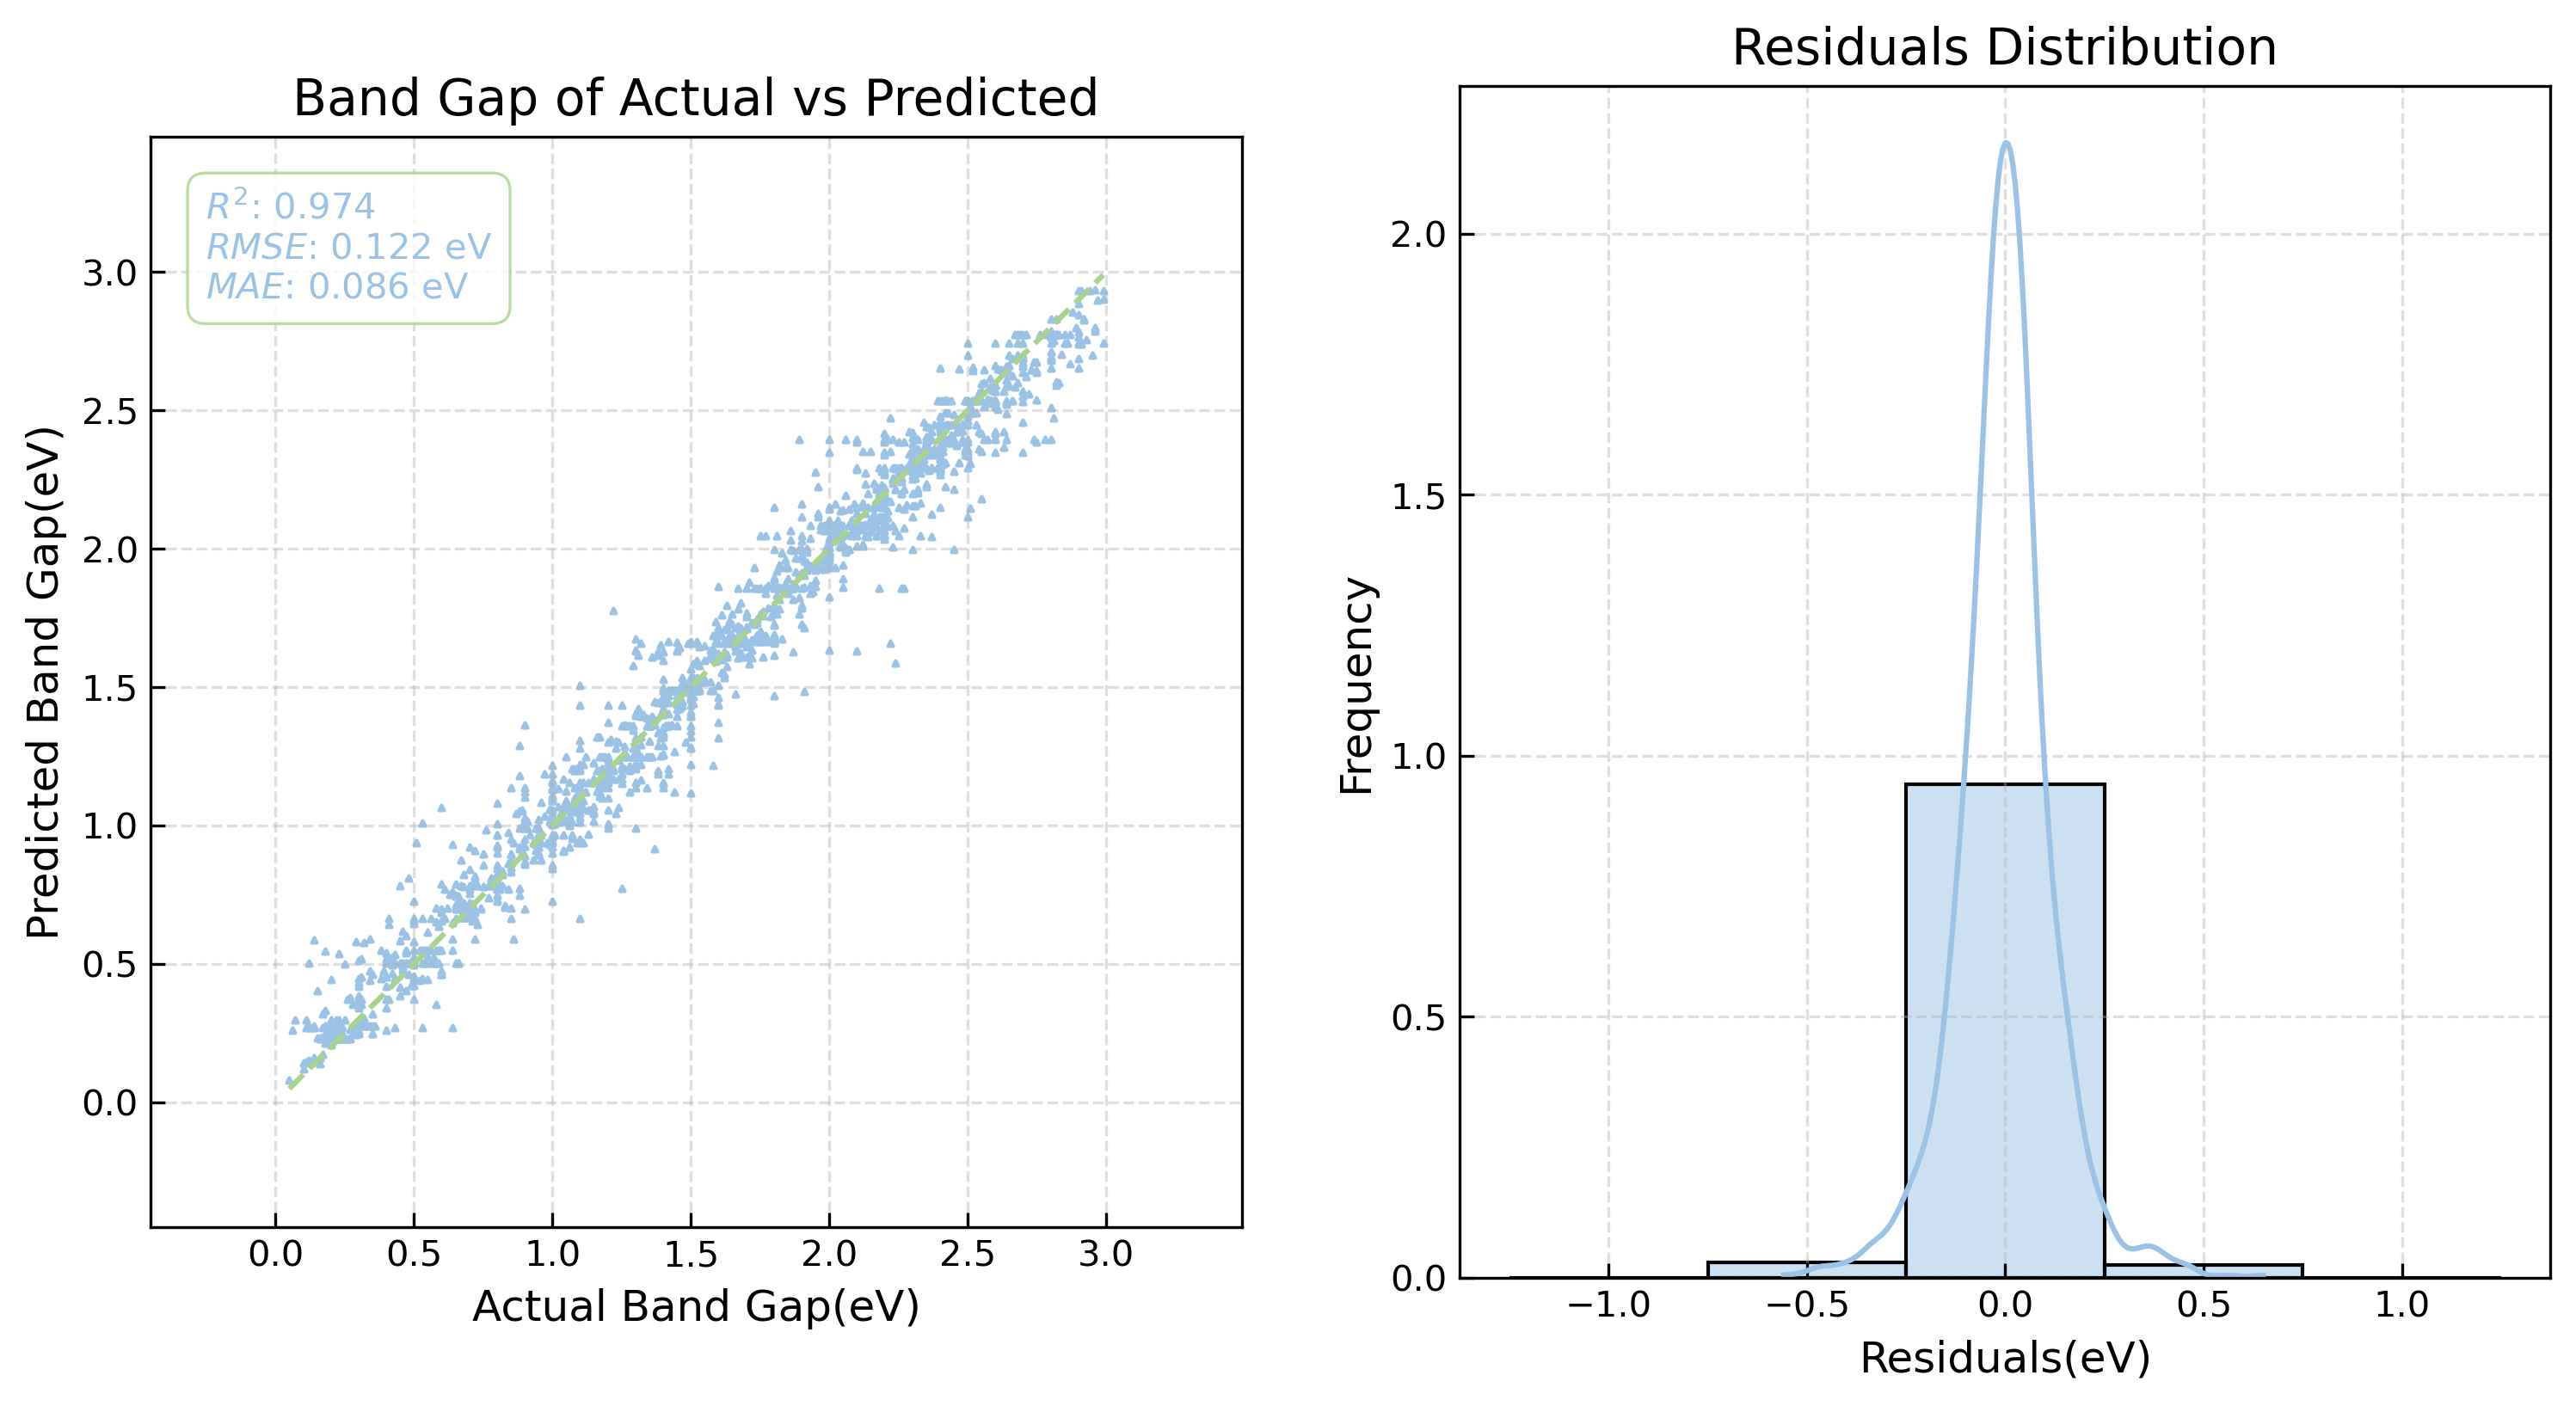


Model Evaluation Results:
Test set size: 1595
Test set: R²: 0.9740 RMSE: 0.1216 MAE: 0.0862 MAPE: 9.4722%
[Test EXP -> EXP] Evaluating EXP LightGBM on EXP test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


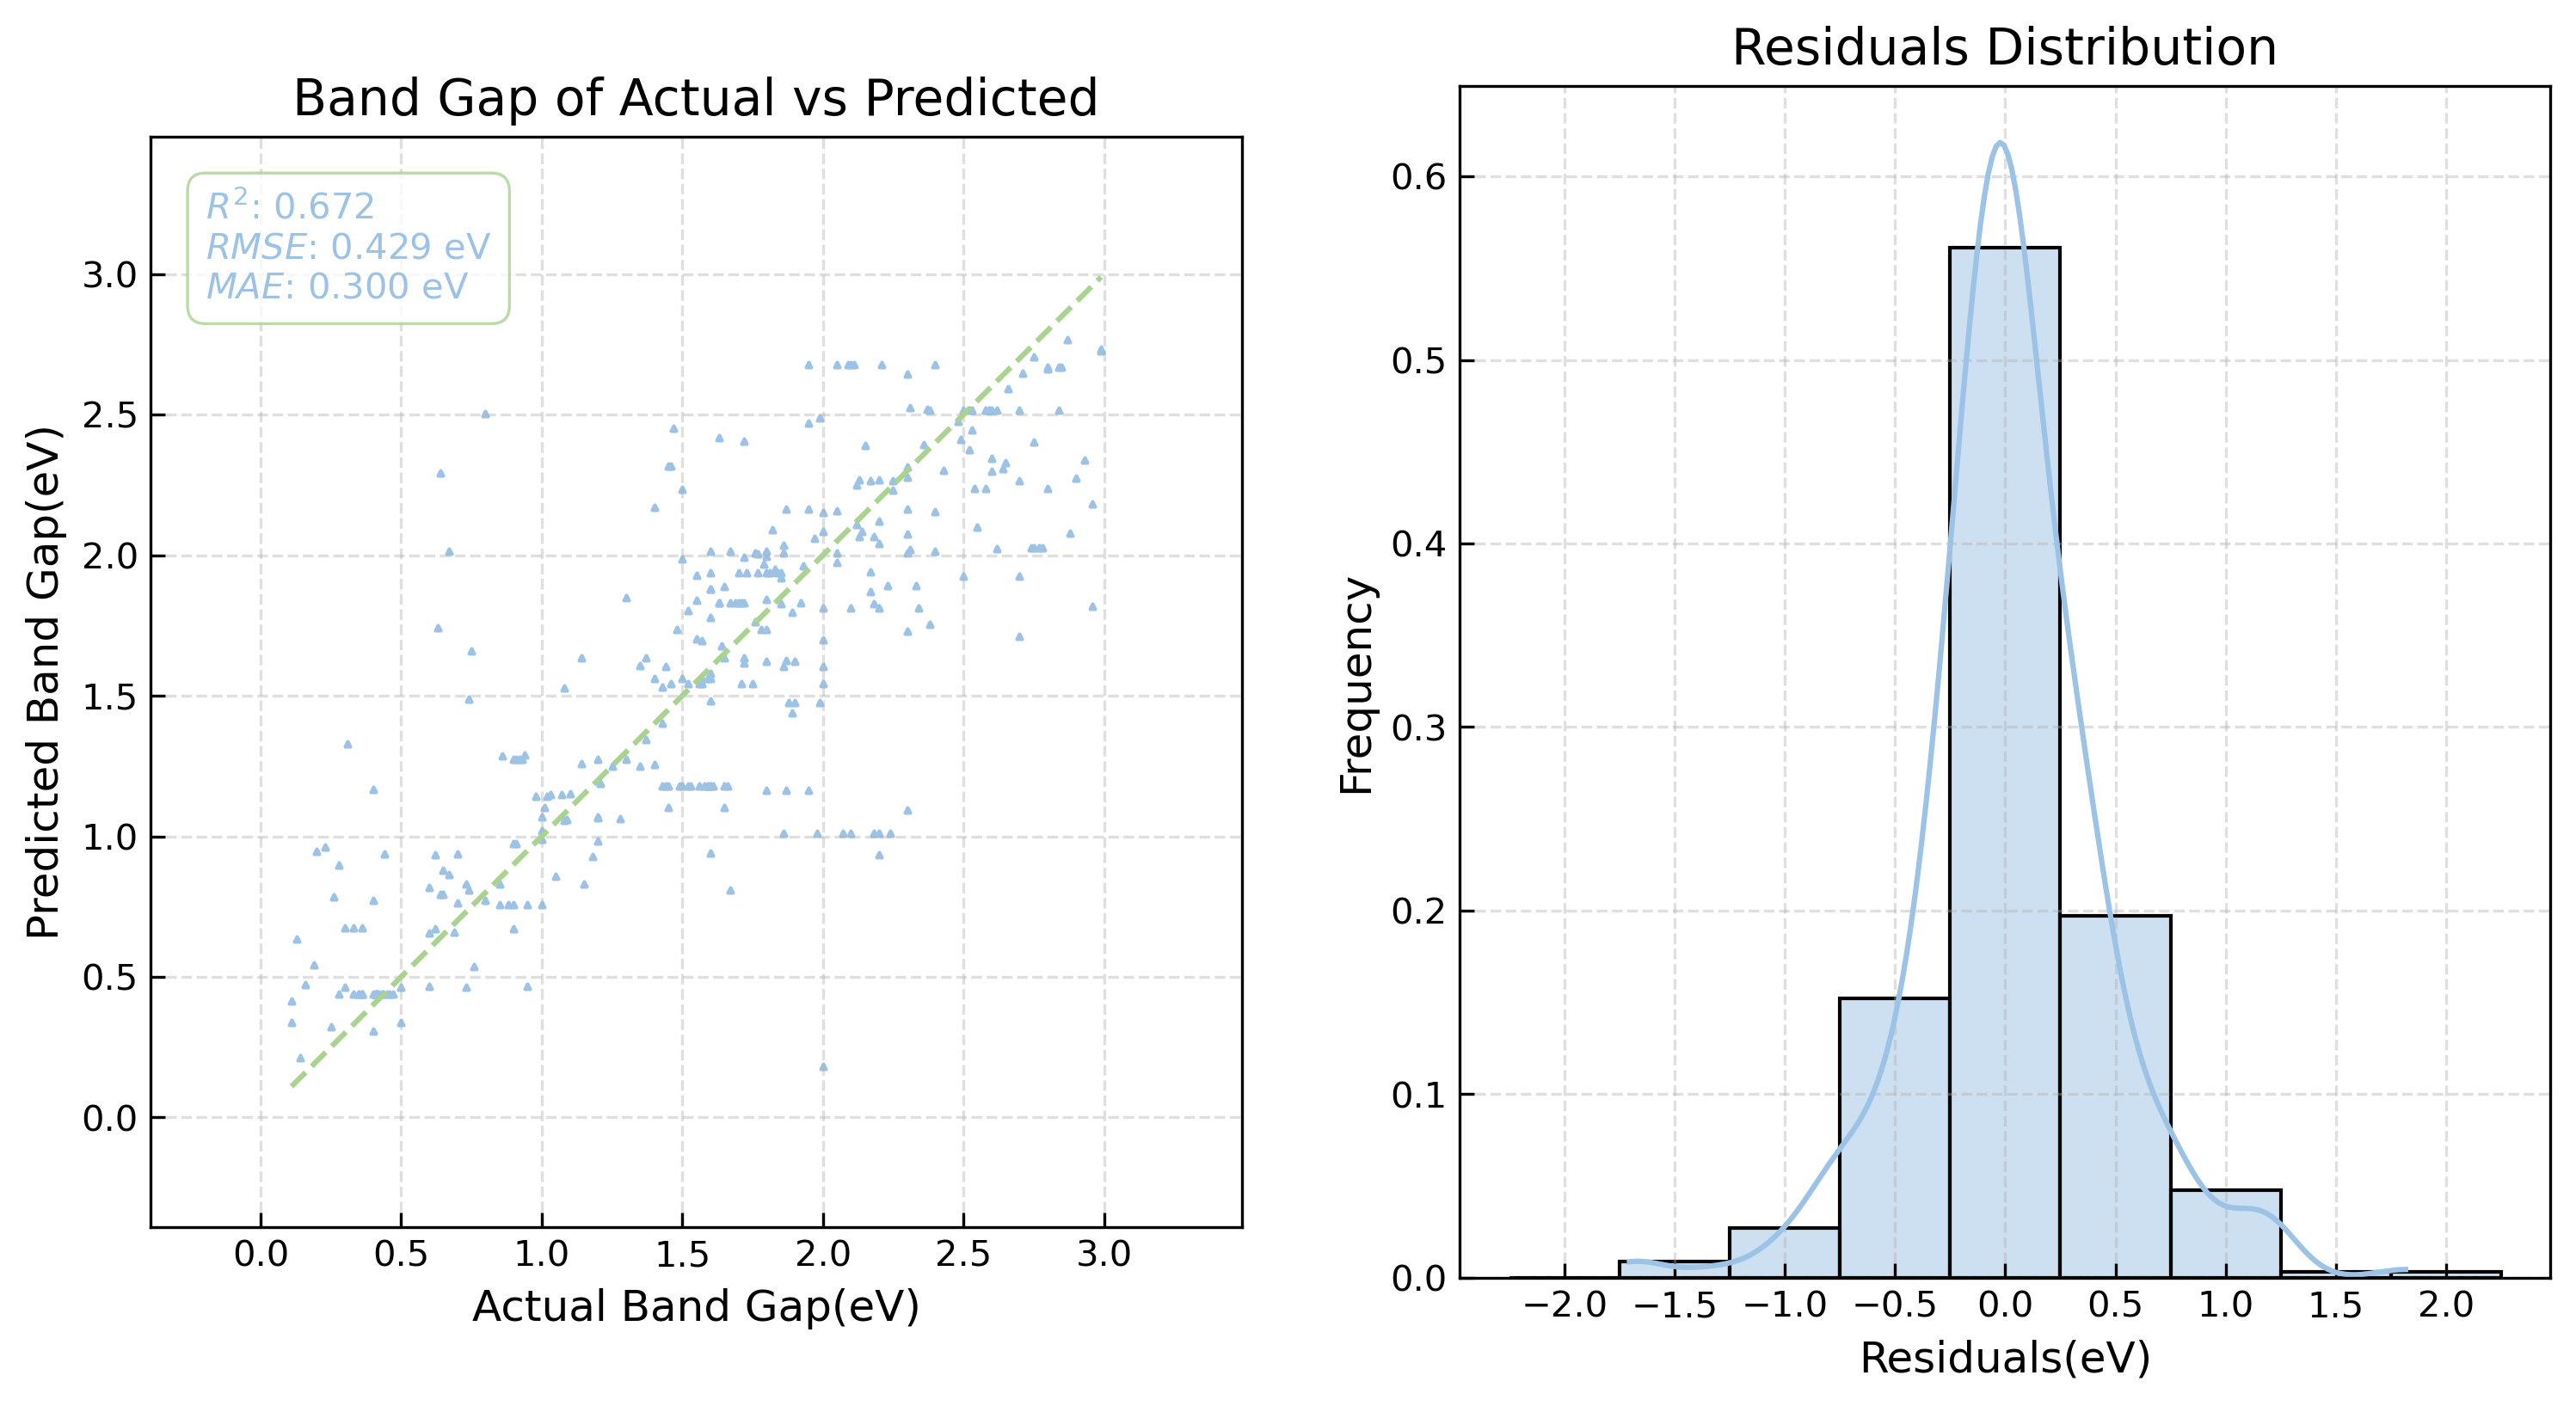


Model Evaluation Results:
Test set size: 335
Test set: R²: 0.6716 RMSE: 0.4293 MAE: 0.3002 MAPE: 29.2646%
[Test EXP -> DFT] Evaluating EXP LightGBM on DFT test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


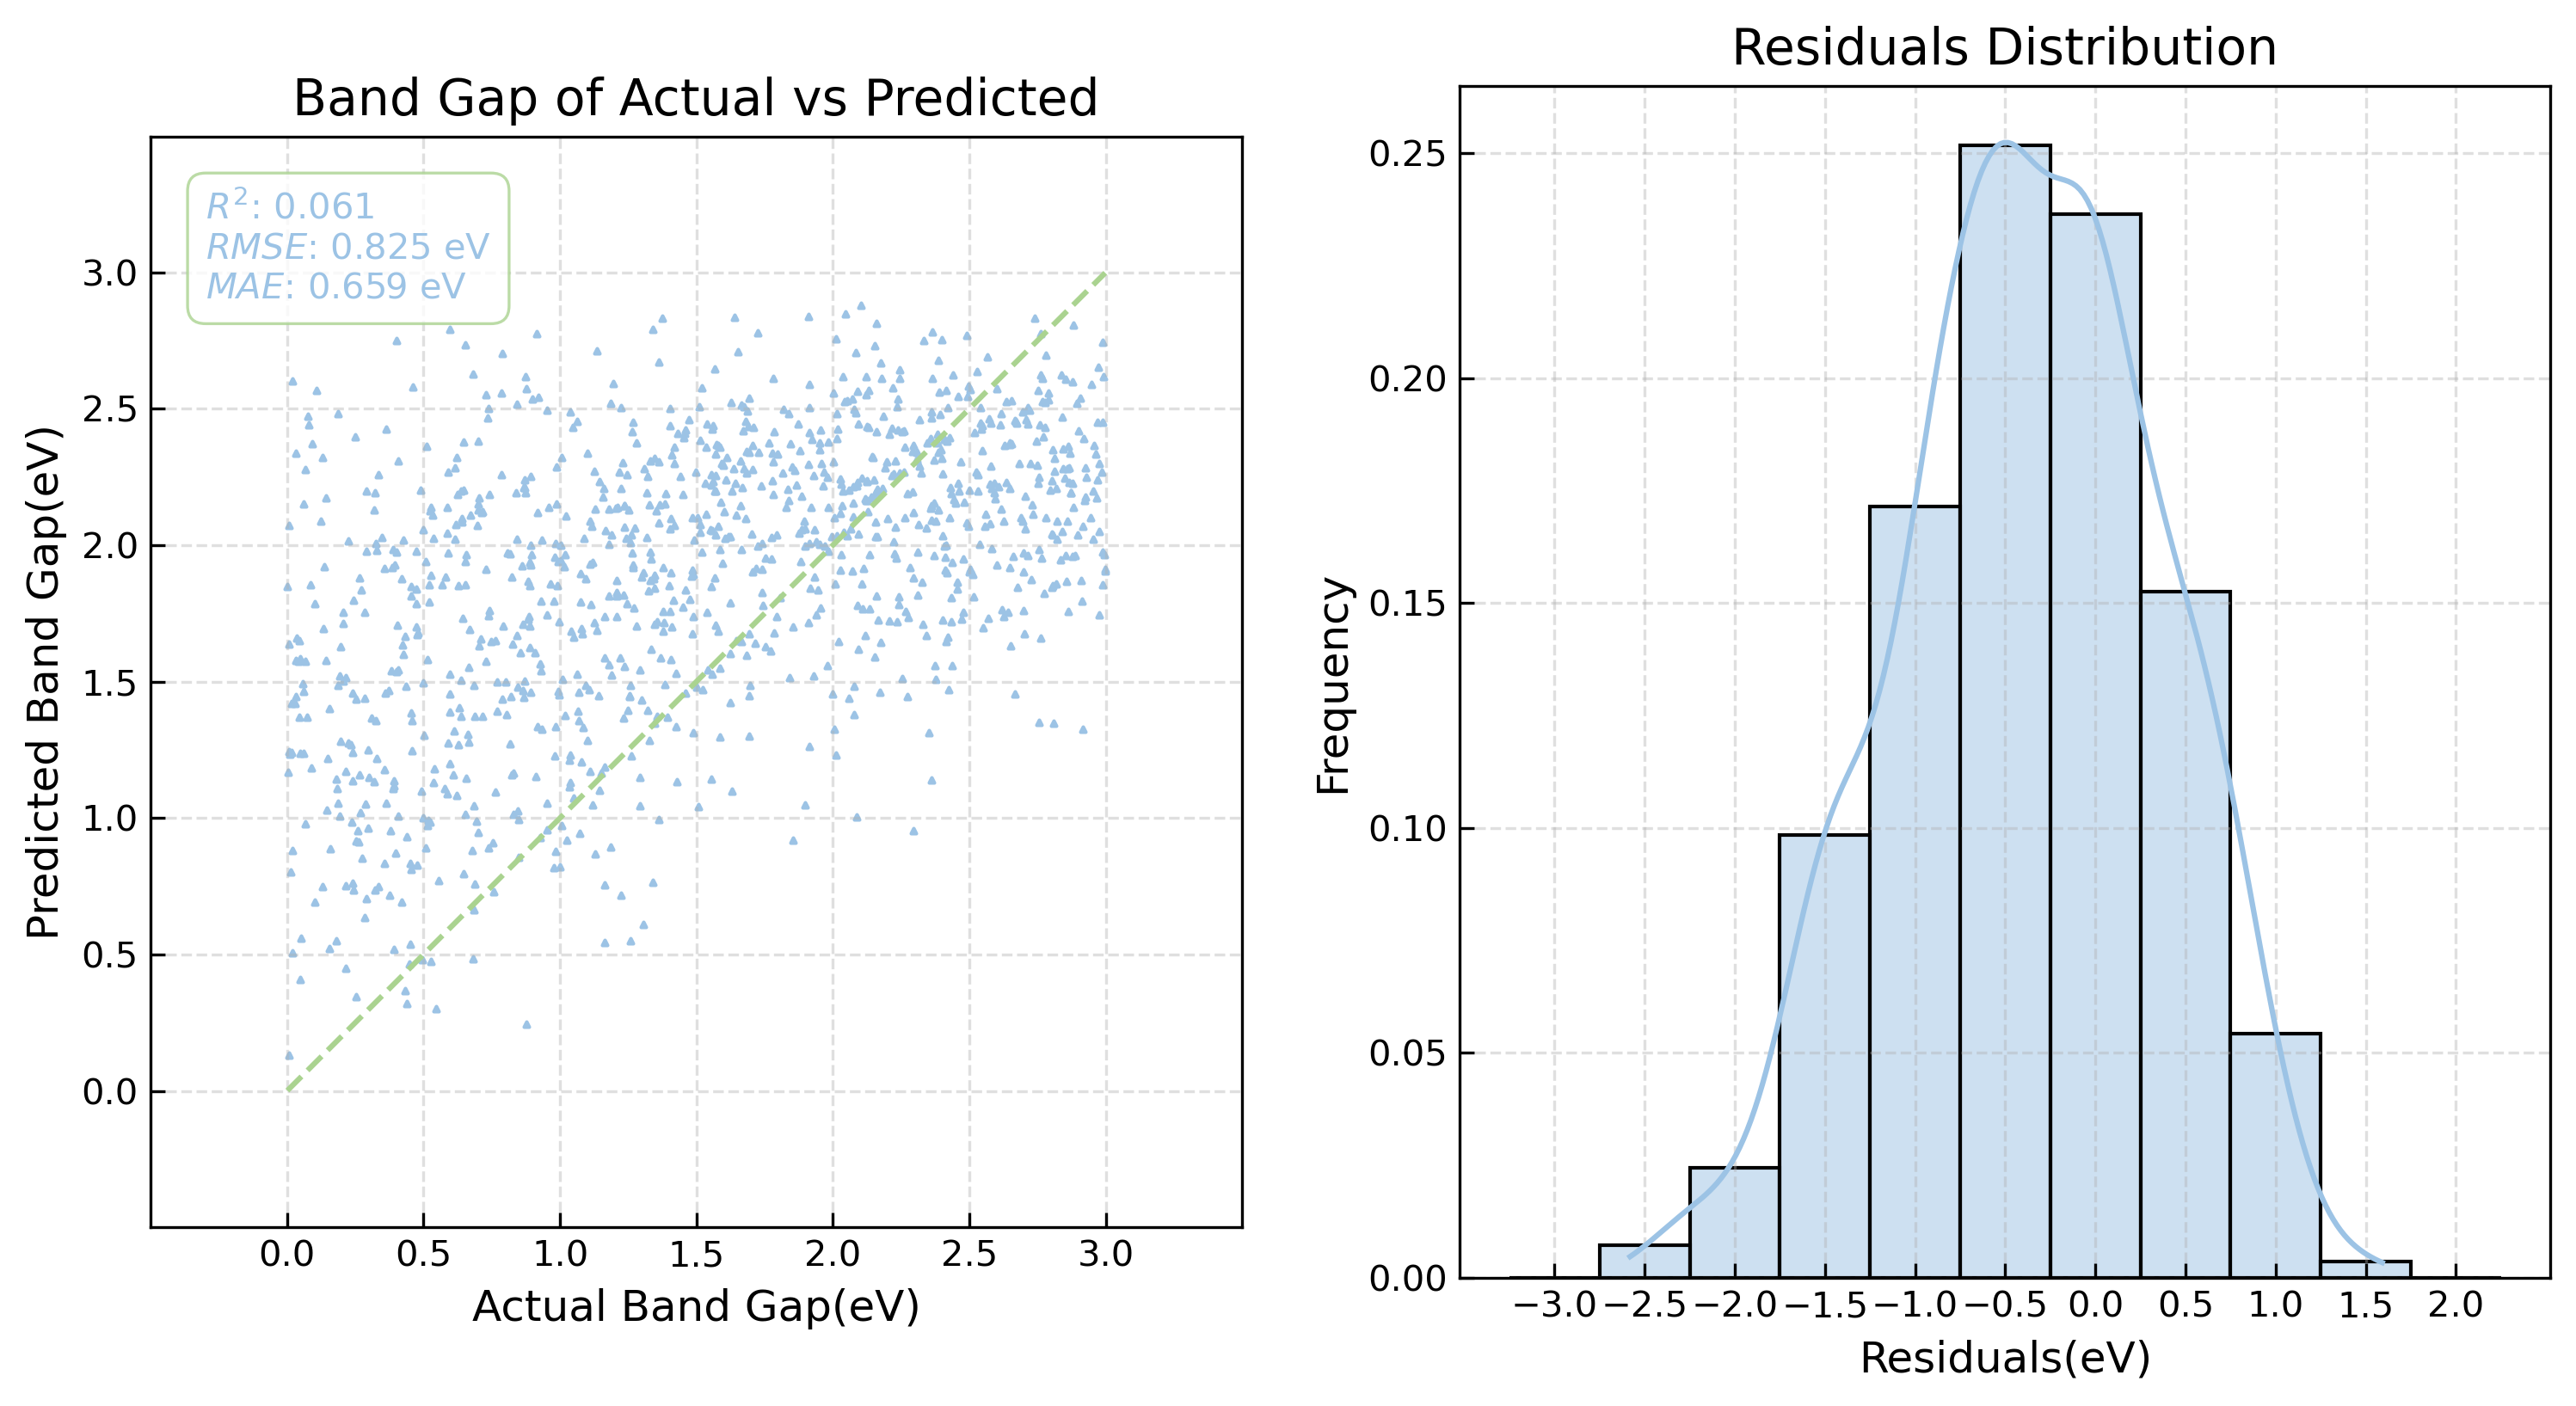


Model Evaluation Results:
Test set size: 1108
Test set: R²: 0.0609 RMSE: 0.8250 MAE: 0.6593 MAPE: 457.8464%


In [16]:
# 
# Train the model with the best hyperparameters on the entire training set
lightgbm_best = LGBMRegressor(learning_rate=0.05, max_depth=9, n_estimators=300,
    subsample=1.0, colsample_bytree=0.7, reg_alpha=0.3, reg_lambda=0.1,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(lightgbm_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [18]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,LightGBM,Train,exp,exp,0.974035,0.121618,0.086240
1,LightGBM,Test,exp,exp,0.671646,0.429317,0.300153
2,LightGBM,Test,exp,dft,0.060896,0.825034,0.659312
